In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/celebal-tech-aqi-prediction/real_2013.csv
/kaggle/input/celebal-tech-aqi-prediction/real_2014.csv
/kaggle/input/celebal-tech-aqi-prediction/real_2016.csv
/kaggle/input/celebal-tech-aqi-prediction/Real_Combine.csv
/kaggle/input/celebal-tech-aqi-prediction/real_2015.csv


In [2]:
df = pd.read_csv('/kaggle/input/celebal-tech-aqi-prediction/Real_Combine.csv')
df.columns



Index(['T', 'TM', 'Tm', 'SLP', 'H', 'VV', 'V', 'VM', 'PM 2.5'], dtype='object')


- **T** (Average Temperature): The average temperature measured over a specific period, usually in degrees Celsius (°C).
- **TM** (Maximum Temperature): The highest temperature recorded during a given period, typically in degrees Celsius (°C).
- **Tm** (Minimum Temperature): The lowest temperature recorded during a given period, usually in degrees Celsius (°C).
- **SLP** (Atmospheric Pressure at Sea Level): The pressure exerted by the Earth's atmosphere at sea level, measured in hectopascals (hPa).
- **H** (Average Relative Humidity): The average amount of moisture present in the air relative to the maximum amount it could hold at a specific temperature, expressed as a percentage (%).
- **VV** (Average Visibility): The average horizontal distance over which objects can be seen clearly in the atmosphere, typically measured in kilometers (Km).
- **V** (Average Wind Speed): The average speed of the wind during a specific period, usually measured in kilometers per hour (Km/h).
- **VM** (Maximum Sustained Wind Speed): The highest sustained wind speed recorded during a given period, typically measured in kilometers per hour (Km/h).

These parameters are commonly used in weather reports and forecasts to provide information about the current and predicted atmospheric conditions.

In [3]:
df.describe()

,T,TM,Tm,SLP,H,VV,V,VM,PM 2.5
count,1093.000000,1093.000000,1093.000000,1093.000000,1093.000000,1093.000000,1093.000000,1093.000000,1092.000000
mean,26.009241,32.482251,19.460201,1008.081885,62.918573,2.003111,6.751510,15.805124,109.090984
std,7.237401,6.679078,7.438653,7.529237,15.709816,0.747541,3.841137,7.308435,84.465790
min,6.700000,9.800000,0.000000,991.500000,20.000000,0.300000,0.400000,1.900000,0.000000
25%,19.300000,27.800000,12.100000,1001.100000,54.000000,1.600000,3.700000,11.100000,41.833333
50%,28.200000,34.200000,21.200000,1008.100000,64.000000,1.900000,6.500000,14.800000,83.458333
75%,31.700000,37.000000,26.000000,1015.000000,74.000000,2.600000,9.100000,18.300000,158.291667
max,38.500000,45.500000,32.700000,1023.200000,98.000000,5.800000,24.400000,57.600000,404.500000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1093 entries, 0 to 1092
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   T       1093 non-null   float64
 1   TM      1093 non-null   float64
 2   Tm      1093 non-null   float64
 3   SLP     1093 non-null   float64
 4   H       1093 non-null   float64
 5   VV      1093 non-null   float64
 6   V       1093 non-null   float64
 7   VM      1093 non-null   float64
 8   PM 2.5  1092 non-null   float64
dtypes: float64(9)
memory usage: 77.0 KB


There is no null values in this dataset

# Outliers

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


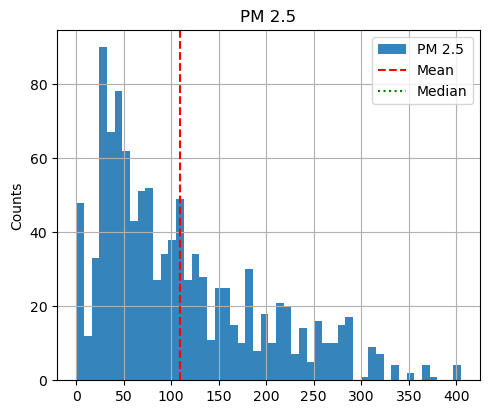

In [6]:
plt.figure(figsize=(12,10))
plt.subplot(2,2,1)
df['PM 2.5'].hist(bins=50,label='PM 2.5',alpha = 0.9)
plt.axvline(np.mean(df['PM 2.5']),ls='--',c='r',label = "Mean")
plt.axvline(np.median(df['PM 2.5']),ls=':',c='g',label="Median")
plt.ylabel("Counts")
plt.title("PM 2.5")
plt.legend()

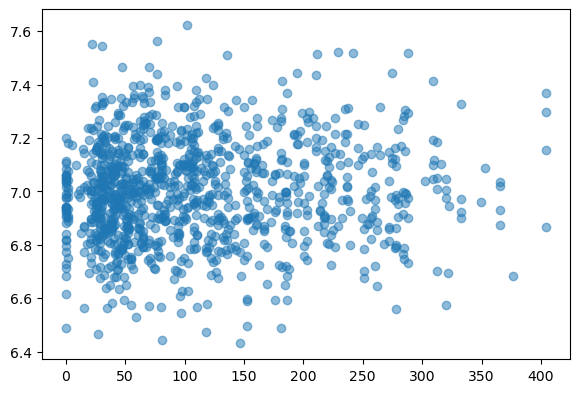

In [7]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,2)
plt.scatter(df['PM 2.5'],np.random.normal(7,0.2,size=df.shape[0]),alpha=0.5)

<Axes: ylabel='PM 2.5'>

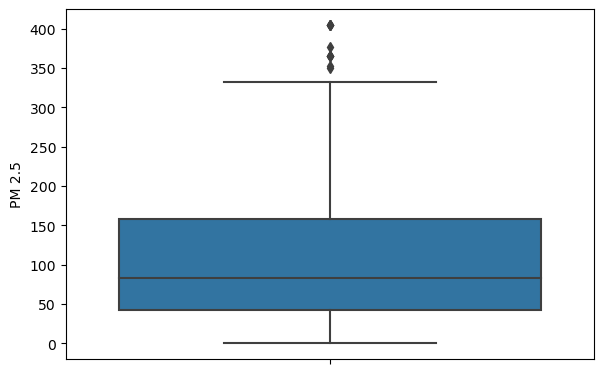

In [8]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,2)
sns.boxplot(y="PM 2.5",data=df)

Data points that fall beyond this threshold are considered outliers and are plotted as individual dots.

In [9]:
print("print before removing the outliers",df.shape)

print before removing the outliers (1093, 9)


# IQR (Inter Quaritile Range)
To define the outlier base value is defined above and below dataset’s normal range namely Upper and Lower bounds, define the upper and the lower bound (1.5*IQR value is considered) :

- **upper = Q3 +1.5*IQR**
- **lower = Q1 – 1.5*IQR**

In the above formula as according to statistics, the 0.5 scale-up of IQR (new_IQR = IQR + 0.5*IQR) is taken, to consider all the data between 2.7 standard deviations in the Gaussian Distribution.


In [10]:
# Calculate the upper and lower limits
q1 = df['PM 2.5'].quantile(0.25)
q3 = df['PM 2.5'].quantile(0.75)
IQR = q3 - q1
lower = q1 - 1.5*IQR
upper = q3 + 1.5*IQR

# Create arrays of Boolean values indicating the outlier rows
upper_array = np.where(df['PM 2.5']>=upper)[0]
lower_array = np.where(df['PM 2.5']<=lower)[0]


data = df
# Removing the outliers
data.drop(index=upper_array,inplace=True)
data.drop(index=lower_array, inplace=True)



In [11]:

print("after removing the outliers:",data.shape)

after removing the outliers: (1082, 9)


Looking the code and the output above, it is difficult to say which data point is an outlier. Let’s try and define a threshold to identify an outlier.

In [12]:
data.head()

,T,TM,Tm,SLP,H,VV,V,VM,PM 2.5
0,7.4,9.8,4.8,1017.6,93.0,0.5,4.3,9.4,219.720833
1,7.8,12.7,4.4,1018.5,87.0,0.6,4.4,11.1,182.187500
2,6.7,13.4,2.4,1019.4,82.0,0.6,4.8,11.1,154.037500
3,8.6,15.5,3.3,1018.7,72.0,0.8,8.1,20.6,223.208333
4,12.4,20.9,4.4,1017.3,61.0,1.3,8.7,22.2,200.645833


<Axes: ylabel='PM 2.5'>

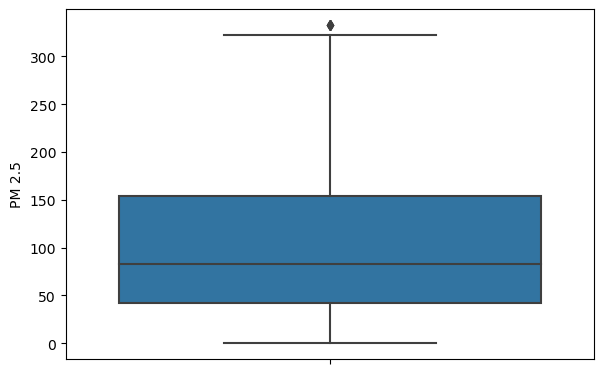

In [13]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,2)
sns.boxplot(y="PM 2.5",data=data)

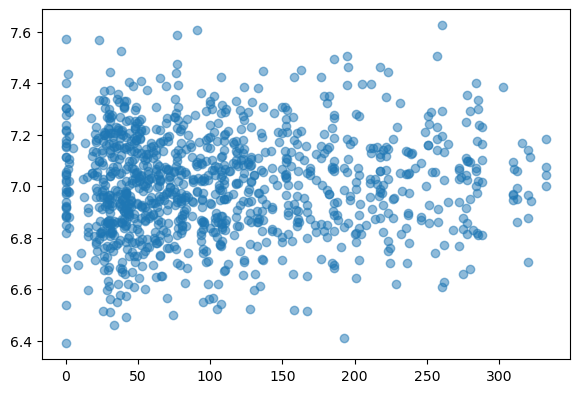

In [14]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,2)
plt.scatter(data['PM 2.5'],np.random.normal(7,0.2,size=data.shape[0]),alpha=0.5)

The update dataset is named as **data**.

This indicates that most of the observations in the dataset have lower concentrations of PM 2.5 particles.

Here are some potential implications of observing a dense linear pattern:
- Temperature Consistency: The dense linear pattern suggests that there is consistency or a predictable relationship between the temperature and minimum temperature. 
- Weather Patterns: In the context of weather data, a dense linear pattern could indicate a consistent weather pattern.


# EDA

In [15]:
df = data

## Histogram

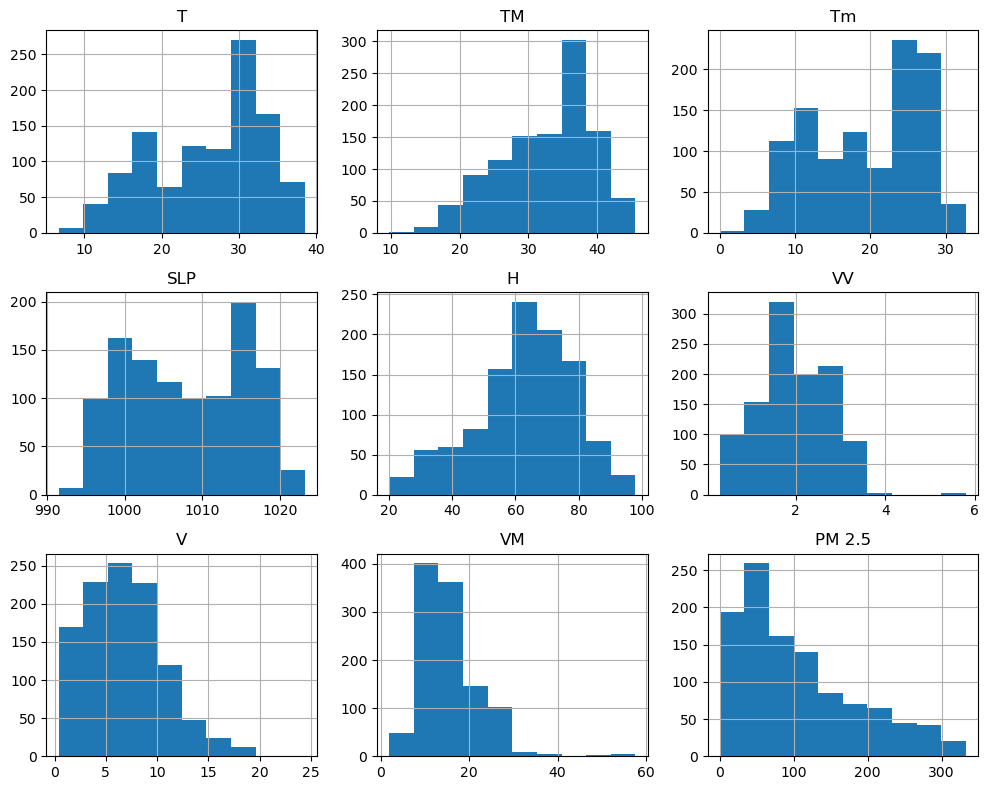

In [16]:
df.hist(figsize=(10, 8))
plt.tight_layout()
plt.show()


**Histograms show the distribution of each numerical variable. Examine the shape, skewness, and potential presence of outliers. It helps identify data patterns, such as normal distribution, bimodal distribution, or skewed distributions.**

## Box plots

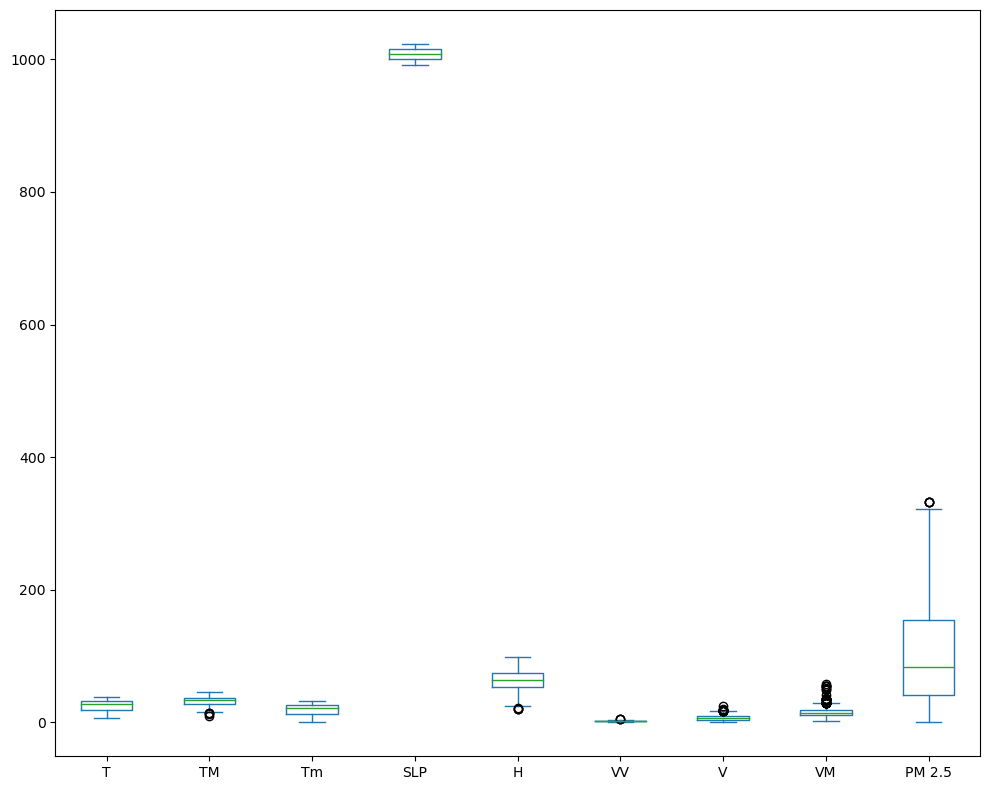

In [17]:
df.plot(kind='box', figsize=(10, 8))
plt.tight_layout()
plt.show()

**Box plots visualize the distribution, central tendency, and spread of each numerical variable. They help identify outliers and assess the presence of skewness or asymmetry in the data.**

## Correlation heatmap

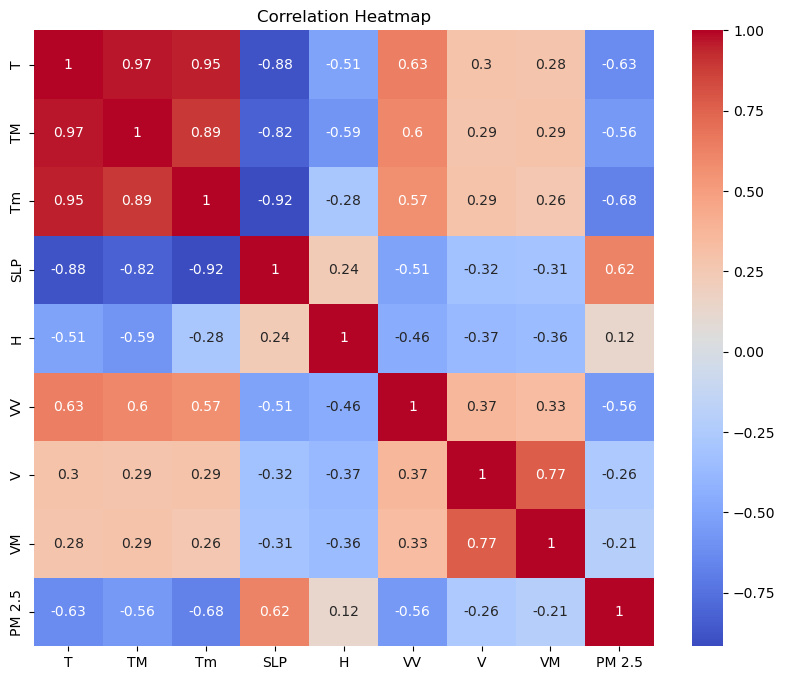

In [18]:
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

**Correlation heatmap: The heatmap illustrates the correlation between pairs of numerical variables. Focus on variables strongly correlated (positive or negative) with 'PM 2.5'. Identify potential predictors that may have a significant impact on 'PM 2.5' levels.**

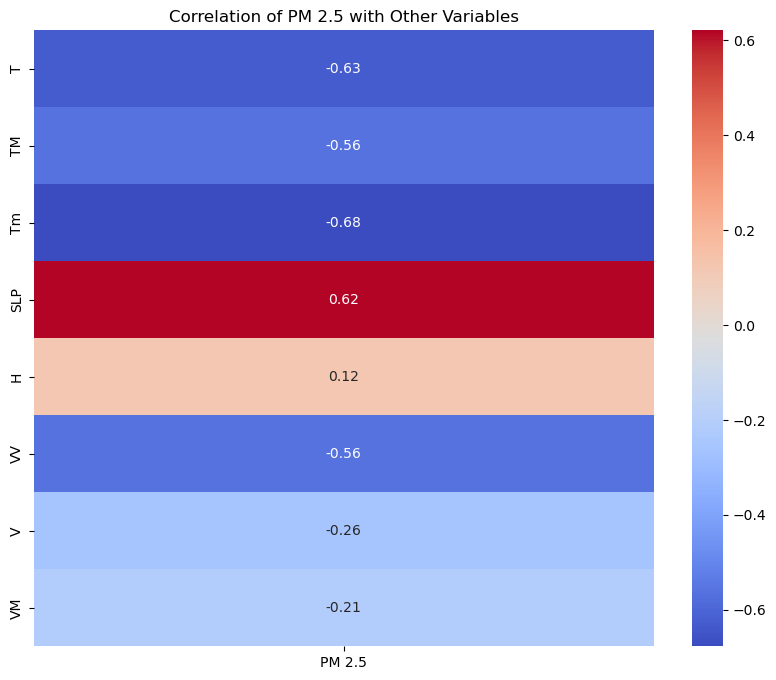

In [19]:
correlation_matrix = data.corr()
pm25_corr = correlation_matrix['PM 2.5']
pm25_corr = pm25_corr.drop('PM 2.5')  # Exclude the correlation with itself

plt.figure(figsize=(10, 8))  # Adjust the figure size if needed
sns.heatmap(pm25_corr.to_frame(), annot=True, cmap='coolwarm')
plt.title('Correlation of PM 2.5 with Other Variables')
plt.show()



## Pair plots

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


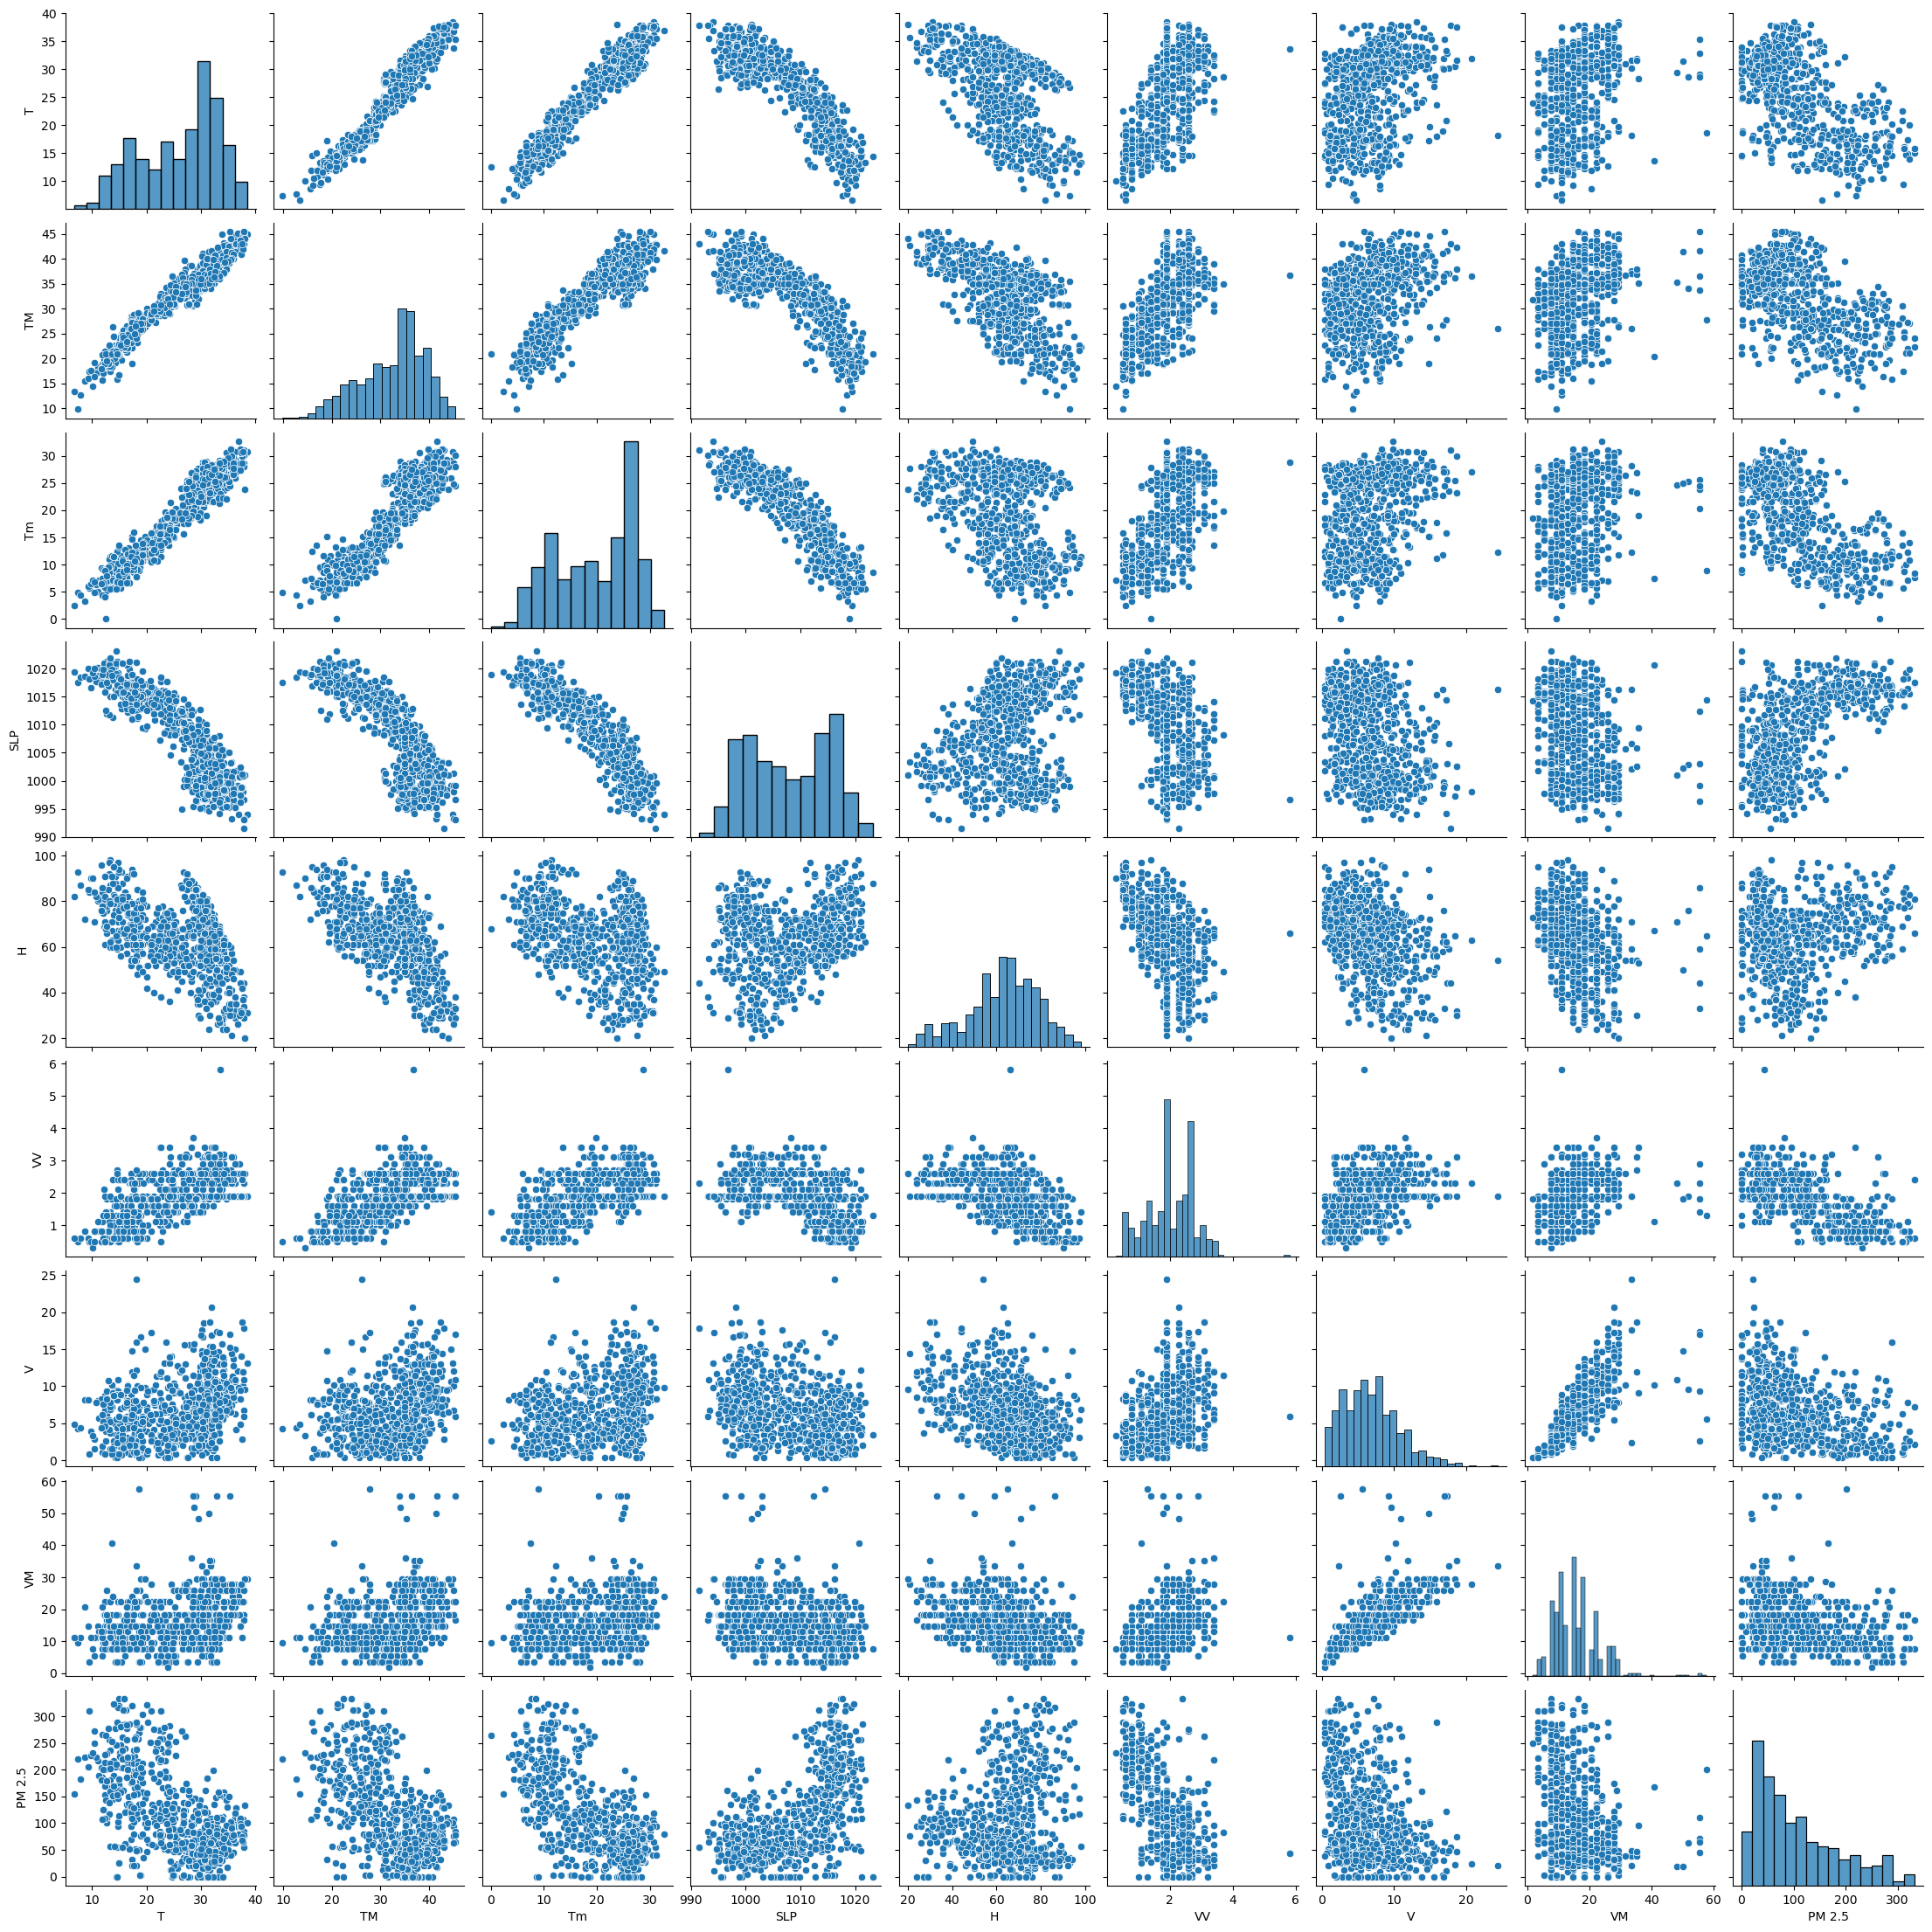

In [20]:
# Pair plots for numeric variables
sns.pairplot(df, diag_kind='hist')
plt.show()

**Pair plots: Pair plots display pairwise relationships between numerical variables. Look for patterns, trends, or potential correlations among variables. Pay attention to how 'PM 2.5' relates to other variables.**